In [1]:
from streetview import POI

In [6]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import numpy as np
from shapely.geometry import Point
from shapely.ops import linemerge, unary_union
from streetview import POI
from math import pi

def _generate_points(road, interval, point, pts_before, pts_after):
    """ Generates points along a line."""
    # Project line for meter-based calculations 
    road = road.to_crs("EPSG:3857")
    point = point.to_crs("EPSG:3857")

    # Merge into one road 
    if len(road) > 1: 
        road = linemerge(unary_union(road.geometry))
    
    # Project the point onto the road, then get distance to this point
    nearest_pt =  road.interpolate(road.project(point.geometry.iloc[0]))
    start_distance = road.project(nearest_pt)
    points = []
    
    for i in range(-pts_before, pts_after + 1):
        # Calculate distance that this point should be from the main one. 
        distance = start_distance + i * interval 
        # Round to zero or max road length so that the resulting point doesn't surpass the road
        distance = max(0, min(distance, road.length))
        # Interpolate point onto road 
        points.append(road.interpolate(distance))

    # Create a GeoDataFrame to store the interpolated points
    gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:3857")
    return gdf


def _calc_headings(points, original_pt):
    # Get coords from original point
    original_x, original_y = original_pt.geometry.iloc[0].coords[0]

    # Find distance between points 
    x_diff = np.array(points["geometry"].x) - original_x
    y_diff = np.array(points["geometry"].y) - original_y

    # Find arctan2 of distance
    headings = np.arctan2(y_diff, x_diff) * (180 / pi)

    # Normalize 
    normed_headings = (headings + 180) % 360
    return normed_headings
    

def get_points(poi: POI, points_before = 0, points_after = 0, interval=15):
    """ Gets a DataFrame of nearest points along the closest road to the POI along with headings facing towards the POI. 
        Args: 
            poi: The point of interest around which points will be located 
            points_before: The number of points to be found before the closest one. 
            points_after: The number of points to be found after the closest one. 
            interval: The distance between each point in meters.
    """
    # Make point into a geodataframe 
    original_pt = gpd.GeoDataFrame(geometry=[Point(poi.coords.lon, poi.coords.lat)], crs="EPSG:4326")
    
    # Make a bounding box around the point 
    point_buffer = original_pt.to_crs(epsg=26916).buffer(200).to_crs("EPSG:4326")
    bbox = point_buffer.total_bounds

    # Retrieve road data within the bounding box from OSM
    tags = {"highway": ["motorway", "trunk", "primary", "secondary", "tertiary", "residential"]}
    osm_roads = ox.features_from_bbox(bbox[3], bbox[1], bbox[2], bbox[0], tags=tags)
    road_lines = osm_roads[osm_roads.geom_type == 'LineString'].to_crs("EPSG:4326")

    # Find the nearest road to the point of interest
    nearest_rd = road_lines.iloc[road_lines.sindex.nearest(original_pt.iloc[0])[1]].iloc[0]
    nearest_rd_name = nearest_rd.get("name")

    # Covnert to geoseries 
    nearest_rd = gpd.GeoSeries([nearest_rd.geometry], crs="EPSG:4326")

    # Get all of the segments of this road within the bounding box, not just one. 
    nearest_rd_all = road_lines[road_lines["name"] == nearest_rd_name]

    # Define interval and generate points along the nearest road
    points = _generate_points(nearest_rd_all, interval, original_pt, points_before, points_after)
    
    points = points.to_crs("EPSG:4326")
    original_pt = original_pt.to_crs("EPSG:4326")

    # Transform original point to coordinates and calculate headings
    headings = _calc_headings(points, original_pt)
    points["heading"] = headings
    # Convert to a dataframe
    df = pd.DataFrame(data={'heading': headings,
                            'lat': points["geometry"].y, 
                            'lon': points["geometry"].x})

    # Convert everything 
    nearest_rd_all = nearest_rd_all.to_crs("EPSG:3857")
    points = points.to_crs("EPSG:3857")
    original_pt = original_pt.to_crs("EPSG:3857")
    return nearest_rd_all, points, original_pt



/home/dev/.local/lib/python3.11/site-packages/pyproj/transformer.py:817: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
/tmp/ipykernel_36352/4014301168.py:71: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  osm_roads = ox.features_from_bbox(bbox[3], bbox[1], bbox[2], bbox[0], tags=tags)
/tmp/ipykernel_36352/4014301168.py:71: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  osm_roads = ox.features_from_bbox(bbox[3], bbox[1], bbox[2], bbox[0], tags=tags)
/home/dev/.local/lib/python3.11/site-packages/pyproj/

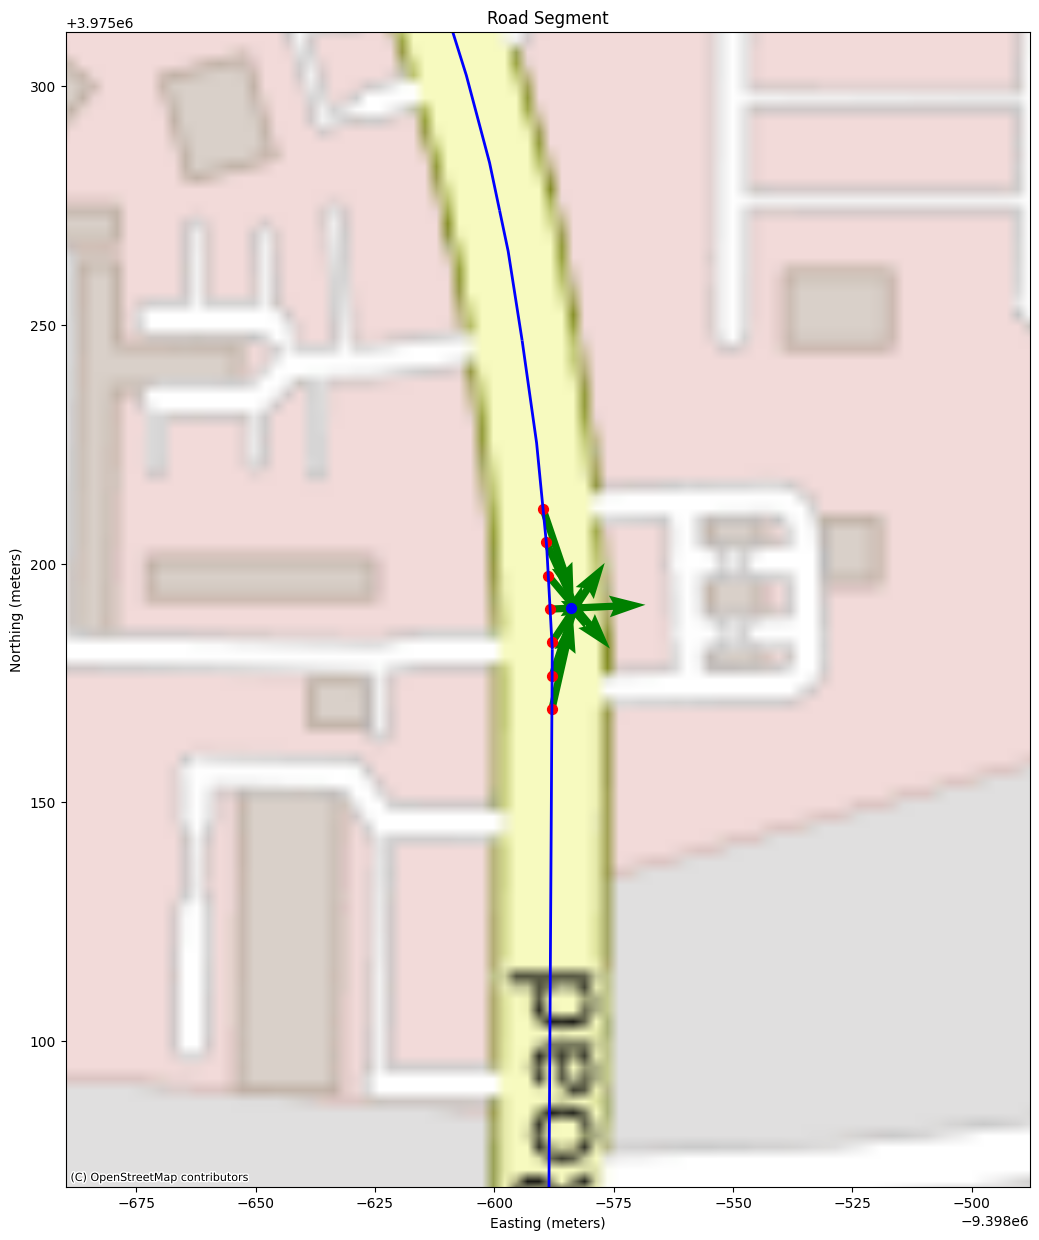

In [7]:
import matplotlib.pyplot as plt
import contextily as ctx

# Get points for test POI
test_pt = POI(lon=-84.428916, lat=33.5998)
test_pt1 = POI(lon=-84.669803, lat=33.517396999999995)

road, points, original_pt = get_points(test_pt, 3, 3, 7)

# Set up plot, expand borders
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')
minx, miny, maxx, maxy = points.total_bounds
ax.set_xlim(minx - 100, maxx + 100)
ax.set_ylim(miny - 100, maxy + 100)

# Plot elements
road.plot(ax=ax, color="blue", linewidth=2)

for i, row in points.iterrows():
    # Calculate dx and dy for each individual point based on its heading
    angle = np.radians(row["heading"])  # Convert heading to radians if it's in degrees
    arrow_length = 20  # Customize this as needed
    dx = arrow_length * np.cos(angle)
    dy = arrow_length * np.sin(angle)

    # Plot each arrow individually
    ax.quiver(row["geometry"].x, row["geometry"].y, dx, dy, angles='xy', scale_units='xy', scale=1, color="green")
    
original_pt.plot(ax=ax, color="blue", marker="o", markersize=50)
points.plot(ax=ax, color="red", marker="o", markersize=50)


# Basemap and other plot details
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=16)
ax.set_title("Road Segment")
ax.set_xlabel("Easting (meters)")
ax.set_ylabel("Northing (meters)")
plt.show()